In [1]:
from fastrenewables.tabular.learner import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.core import *
import pandas as pd
import zipfile
import zipfile, re, os
import numpy as np
from fastai.torch_basics import *
from fastai.metrics import rmse, mae
from fastai.tabular.all import *

In [2]:
def read_single_file(file_name):
    df = pd.read_hdf(file_name, key="powerdata")
    return df

In [3]:
def extract_single_file(path_to_zip_file, directory_to_extract_to):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(path=directory_to_extract_to)

In [4]:
def extract_zip_in_folder(toFolder):
    for root, dirs, files in os.walk(toFolder):
        for filename in files:
            if re.search(r'\.zip$', filename):
                fileSpec = os.path.join(root, filename)
                extract_single_file(fileSpec, root)

In [5]:
def get_wind_speed(x, y):
    z = np.sqrt(x ** 2 + y ** 2)
    return z

def get_wind_direction(x, y):
    z = get_wind_speed(x, y)
    phi = 2 * np.arctan(y / (x + z + 1e-16))
    return phi

In [6]:
def read_csv(file_name):
    df = pd.read_csv(file_name, sep=",")
    df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, infer_datetime_format=True, utc=True)
    df = df.rename(columns={"TIMESTAMP": "TimeUTC", "TARGETVAR": "PowerGeneration", "ZONEID":"TaskID"})
    df.set_index("TimeUTC", inplace=True)
    
    return df

In [7]:
def create_complete_task(file_name_task, file_name_solution=None):
    df = read_csv(file_name_task)
    
    cols = [("U10", "V10"),("U100", "V100")]
        
    for c in cols:
        ws = get_wind_speed(df[c[0]].values, df[c[1]].values)
        wd = get_wind_direction(df[c[0]].values, df[c[1]].values)
        w_height = "100" if "100" in c[0] else "10"
        
        df[f"WindSpeed{w_height}m"] = ws
        df[f"SinWindDirection{w_height}m"] = np.sin(wd)
        df[f"CosWindDirection{w_height}m"] = np.cos(wd)   
    
    df["WindSpeed10m_t_m1"] = df.WindSpeed10m.shift(1).fillna(method='bfill')
    df["WindSpeed10m_t_p1"] = df.WindSpeed10m.shift(-1).fillna(method='ffill')
    
    df["WindSpeed100m_t_m1"] = df.WindSpeed100m.shift(1).fillna(method='bfill')
    df["WindSpeed100m_t_p1"] = df.WindSpeed100m.shift(-1).fillna(method='ffill')
    
    if file_name_solution is not None:
        df_solution = read_csv(file_name_solution)
        df_solution = df_solution[df_solution.TaskID==df.TaskID[0]]
        
#         check if timestamps match
        if (df.index == df_solution.index).sum() == df.shape[0]:
            
            df["PowerGeneration"] = df_solution.PowerGeneration.values
        else:
            raise Warning("Timestamps do not match.")
    df.dropna(inplace=True)
    return df  

In [8]:
def merge_dfs(first_list, second_list):
    dfs = []
    if len(first_list)!= len(second_list):
        raise ValueError("Different lenghts of list.")
        
    for idx in range(len(first_list)):
        df1, df2 = first_list[idx], second_list[idx]
        if df1.TaskID[0] != df2.TaskID[0]:
            raise ValueError("Not sorted correctly. Not matching task ids.")
        dfs.append(pd.concat([df1, df2], axis=0))
        
    return dfs

In [9]:
def prepare_for_tasks(dfs, gefcom_task=1):
    
    start_date = pd.to_datetime("2012-10-01", utc=True) + pd.DateOffset(months=gefcom_task-1)
    end_date = last_day_of_month(start_date)
    
    dfs_train = []
    for df in dfs:
        mask = df.index < start_date
        dfs_train.append(df[mask])
        
    dfs_test = []
    for df in dfs:
        mask = (df.index >= start_date) & (df.index <= end_date)
        dfs_test.append(df[mask])

    return pd.concat(dfs_train, axis=0), pd.concat(dfs_test, axis=0)

In [10]:
import datetime

def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [11]:
# uncomment if file is not yet downloaded

# !wget "https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip"
# extract_single_file("GEFCom2014.zip", "./")
# extract_single_file("GEFCom2014 Data/GEFCom2014-W_V2.zip", "./")
# extract_zip_in_folder("./Wind/")

In [12]:
ls

'GEFCom2014 Data'/   gefcom.ipynb   preprocessing.py
 GEFCom2014.zip      models/        Wind/


In [13]:
files_task = !ls {"./Wind/Task\ 15/Task15_W_Zone1_10/*csv"}

In [14]:
dfs_task = [create_complete_task(f) for f in files_task]
len(dfs_task)

10

In [15]:
files_task_solution = !ls {"./Wind/Task\ 15/TaskExpVars15_W_Zone1_10/*csv"}
dfs_task_solution = [create_complete_task(f, './Wind/Solution to Task 15/solution15_W.csv') for f in files_task_solution]

In [16]:
dfs = merge_dfs(dfs_task, dfs_task_solution)

In [17]:
GEFCOM_TASK = 3

In [18]:
df_train, df_test = prepare_for_tasks(dfs, gefcom_task=GEFCOM_TASK)

In [19]:
df_train.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,SinWindDirection100m,CosWindDirection100m,WindSpeed10m_t_m1,WindSpeed10m_t_p1,WindSpeed100m_t_m1,WindSpeed100m_t_p1
TimeUTC,,,,,,,,,,,,,,,,
2012-01-01 01:00:00+00:00,10,0.594361,1.655790,-4.649593,2.024257,-5.992232,4.935621,-0.942048,0.335477,6.324908,-0.947402,0.320045,4.935621,4.718060,6.324908,5.929832
2012-01-01 02:00:00+00:00,10,0.569679,2.178609,-4.184944,2.623141,-5.318086,4.718060,-0.887005,0.461759,5.929832,-0.896836,0.442363,4.935621,3.934493,6.324908,4.839190


In [20]:
df_train.dtypes

TaskID                    int64
PowerGeneration         float64
U10                     float64
V10                     float64
U100                    float64
V100                    float64
WindSpeed10m            float64
SinWindDirection10m     float64
CosWindDirection10m     float64
WindSpeed100m           float64
SinWindDirection100m    float64
CosWindDirection100m    float64
WindSpeed10m_t_m1       float64
WindSpeed10m_t_p1       float64
WindSpeed100m_t_m1      float64
WindSpeed100m_t_p1      float64
dtype: object

In [21]:
df_train.TaskID.unique()

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [22]:
cat_names = ["TaskID"]

cont_names = ['U10', 'V10', 'U100', 'V100',
       'WindSpeed10m', 'SinWindDirection10m', 'CosWindDirection10m',
       'WindSpeed100m', 'SinWindDirection100m', 'CosWindDirection100m',
       'WindSpeed10m_t_m1', 'WindSpeed10m_t_p1', 'WindSpeed100m_t_m1',
       'WindSpeed100m_t_p1']
y_names = ["PowerGeneration"]


In [23]:
dls = RenewableDataLoaders.from_df(df_train, 
                                   cat_names=cat_names, 
                                   cont_names=cont_names, 
                                   y_names=y_names,
                                   bs=24*30, 
                                   shuffle=True
                                  )

In [24]:
dls.dataset.items.WindSpeed10m.describe()

count    6.431200e+04
mean    -2.552173e-17
std      1.000008e+00
min     -2.093536e+00
25%     -7.834208e-01
50%     -1.611135e-01
75%      6.138224e-01
max      5.939645e+00
Name: WindSpeed10m, dtype: float64

In [25]:
dls.train_ds.items.head(2)

,TaskID,PowerGeneration,U10,V10,U100,V100,WindSpeed10m,SinWindDirection10m,CosWindDirection10m,WindSpeed100m,...,WindSpeed10m_t_m1,WindSpeed10m_t_p1,WindSpeed100m_t_m1,WindSpeed100m_t_p1,MonthSin,MonthCos,DaySin,DayCos,HourSin,HourCos
TimeUTC,,,,,,,,,,,,,,,,,,,,,
2012-04-09 06:00:00+00:00,4,0.546629,0.490692,2.073385,0.388503,1.726231,1.264009,1.298084,0.414281,0.778119,...,1.065078,1.114744,0.544539,0.696200,0.866025,-0.5,0.968077,-0.250653,1.000000,6.123234e-17
2012-04-19 23:00:00+00:00,5,0.005131,-0.277701,-0.545862,-0.117566,-0.394867,-1.406774,-1.612739,-0.302139,-1.775667,...,-1.535991,-1.388810,-2.014313,-1.748035,0.866025,-0.5,-0.651372,-0.758758,-0.258819,9.659258e-01


In [26]:
class Quantile_Score(torch.nn.Module):
    
    def reshape_1(self, x):
        return x.view(x.size()[0],1)
    
    def __init__(self, taus=[0.25, 0.5, 0.75]):
        super(Quantile_Score, self).__init__()
        
        self.taus =  torch.autograd.Variable(torch.from_numpy(np.array(taus, dtype=np.float32)), \
                                             requires_grad=False)
        
        self.taus = self.reshape_1(self.taus).t()
        
        if torch.cuda.is_available(): self.taus = self.taus.cuda()
        
    def forward(self, y_hat, y):
        """
        Example:
            y = np.array([0.2, 0.1, 0.3, 0.4])
            tau=np.array([0.25,0.5,0.75])
            for each sample we have one row 
            y_hat = np.array([[0, 0.2, 0.3], 
                          [0.05, 0.1, 0.35], 
                          [0.2, 0.3, 0.6],
                          [0.3, 0.4, 0.45],])
            res = array([0.125 , 0.2   , 0.25  , 0.0625])
        """
        
        y = self.reshape_1(y)
        v = y - y_hat
        
        r = (torch.abs(v*(v>0).float()) * self.taus + \
             torch.abs(v*(v<0).float()) * (1-self.taus))

        # this would calculate the loss for each sample
        # r =  torch.sum(r,dim=1)
        r =  torch.sum(r)
        
        return r


In [27]:
quantiles = np.arange(0.01,1,0.01)
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [28]:
n_out = len(quantiles)
# n_out=1
learn = renewable_learner(dls, 
                          layers=[len(cont_names), 200, 300, 400,  n_out],
#                           metrics=[rmse, mae], 
                           n_out=n_out, 
                          loss_func=Quantile_Score(taus=list(quantiles))
                         )

In [29]:
learn.model

MultiLayerPerceptron(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(11, 6)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (final_activation): Identity()
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=20, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=300, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=300, out_features=400, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, 

In [30]:
learn.lr_find()
# plt.show()

SuggestedLRs(valley=0.0003311311302240938)

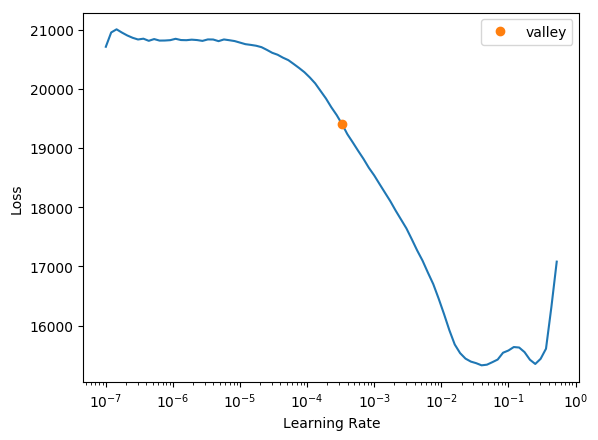

In [31]:
plt.show()

In [32]:
lr=1e-3

In [33]:
learn.fit_one_cycle(5, lr_max=lr)

epoch,train_loss,valid_loss,time
0,11597.845703,6154.627930,00:01
1,4650.959473,3295.514404,00:00
2,3404.852783,2999.829590,00:00
3,3103.565674,2897.665039,00:00
4,2981.649902,2849.258789,00:00


In [34]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,time
0,3100.470459,2946.022949,00:00
1,3052.757080,2922.100098,00:00
2,3021.216064,2851.244873,00:00
3,2964.076904,2833.902588,00:00
4,2945.917725,2817.937744,00:00
5,2941.656494,2817.181396,00:00
6,2913.098145,2857.478271,00:00
7,2893.578857,2778.353760,00:00
8,2895.033691,2842.195068,00:00
9,2887.066162,2795.059082,00:00


In [35]:
# learn.fit(10, lr=lr)

In [36]:
to_test = dls.train_ds.new(df_test)
to_test.setup()
to_test.items.WindSpeed100m.describe()

count    7.210000e+03
mean    -1.389550e-16
std      1.000069e+00
min     -2.812462e+00
25%     -6.862164e-01
50%     -5.484845e-03
75%      7.133237e-01
max      3.003750e+00
Name: WindSpeed100m, dtype: float64

In [37]:
dl_test = to_test.dataloaders(shuffle=False, drop_last=False)

In [38]:
yhat = learn.model(torch.tensor(to_test.cats.values).long().to("cuda:0"), torch.tensor(to_test.conts.values).float().to("cuda:0"))
yhat = to_np(yhat)

In [39]:
yhat.shape

(7210, 99)

In [40]:
# sort to avoid quantile crissing
yhat = np.sort(yhat, axis=1)

In [41]:
y = to_test.ys.values

In [42]:
y.shape

(7210, 1)

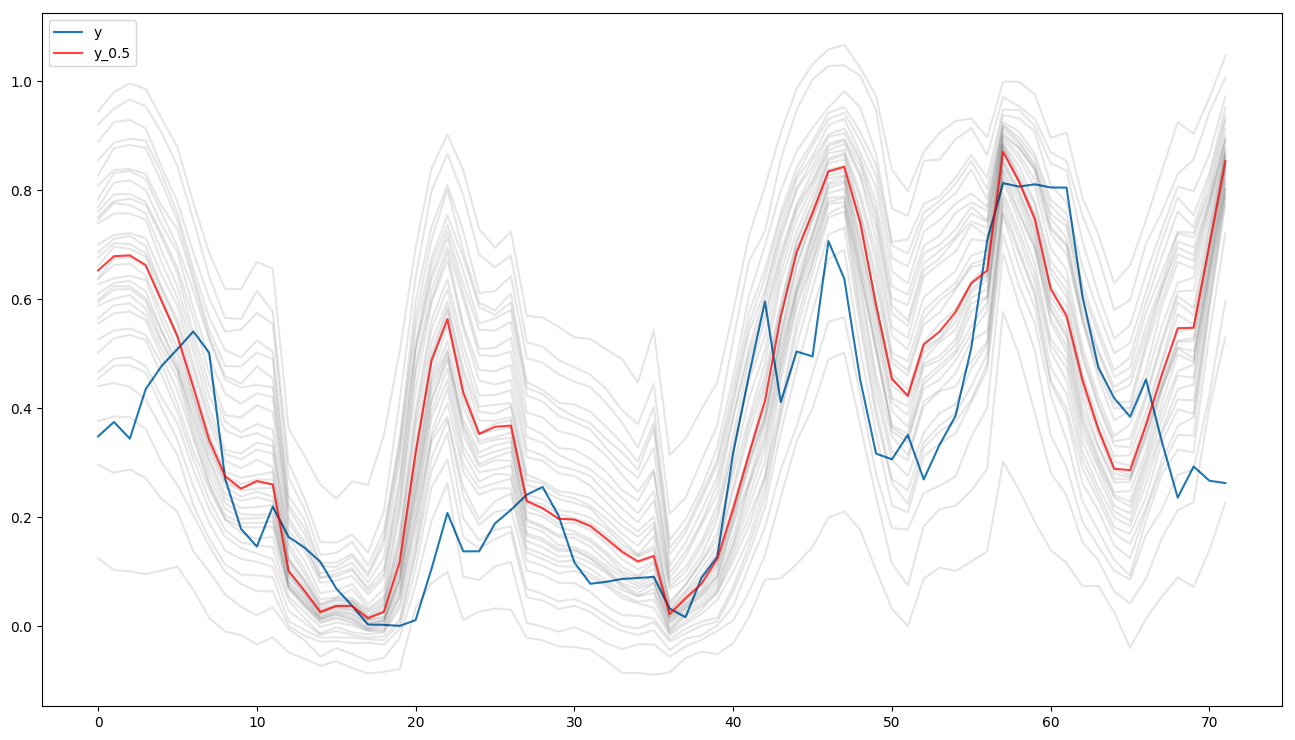

In [48]:
plt.figure(figsize=(16,9))
start = 10
end = start+24*3
plt.plot(y[start:end], label="y")
for q_i in range(0, yhat.shape[1], 3):
    plt.plot(yhat[start:end, q_i], alpha=0.1, c="black")
    
plt.plot(yhat[start:end, len(quantiles)//2], alpha=0.75, c="red", label="y_0.5")
# plt.ylim(-1,2)
plt.legend()
plt.show()